In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score , mean_squared_error

In [2]:
listings = pd.read_csv("../data/processed/listings_encoded.csv", index_col=0)

In [3]:
listings.columns 

Index(['host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count_entire_homes', 'reviews_per_month',
       'amenity_count', 'has_luxury', 'has_kitchen_full', 'has_kitchen_basic',
       'has_safety', 'has_tech', 'has_comfort', 'has_storage', 'has_cleaning',
       'has_family', 'has_entertainment', 'has_hosting', 'luxury_count',


In [4]:
import seaborn as sns
from scipy import stats

def analyze_data_distribution(df):
    """Analyze the distribution of features to determine if normalization is needed"""
    print("=== DATA DISTRIBUTION ANALYSIS ===")
    
    # Get numeric columns only
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"Found {len(numeric_cols)} numeric columns")
    
    # Calculate basic statistics
    stats_df = df[numeric_cols].describe()
    print("\nBasic Statistics:")
    print(stats_df.round(2))
    
    # Check for skewness
    skewness = df[numeric_cols].skew()
    print(f"\nSkewness Analysis (values > 2 or < -2 indicate high skewness):")
    highly_skewed = skewness[(skewness > 2) | (skewness < -2)]
    if len(highly_skewed) > 0:
        print("Highly skewed features:")
        print(highly_skewed.round(2))
    else:
        print("No highly skewed features found")
    
    # Check scale differences
    print(f"\nScale Analysis:")
    means = df[numeric_cols].mean()
    stds = df[numeric_cols].std()
    
    print("Top 10 features by standard deviation:")
    print(stds.sort_values(ascending=False).head(10).round(2))
    
    # Calculate coefficient of variation (std/mean) to see relative variability
    cv = (stds / means).replace([np.inf, -np.inf], np.nan).dropna()
    print(f"\nCoefficient of Variation (std/mean) - Top 10:")
    print(cv.sort_values(ascending=False).head(10).round(2))
    
    return numeric_cols, highly_skewed, stats_df

# Run this first step
numeric_cols, highly_skewed, stats_df = analyze_data_distribution(listings)

=== DATA DISTRIBUTION ANALYSIS ===
Found 66 numeric columns

Basic Statistics:
       host_listings_count  host_total_listings_count  latitude  longitude  \
count              8898.00                    8898.00   8898.00    8898.00   
mean                 26.06                      31.07     52.51      13.40   
std                  93.27                     116.98      0.03       0.07   
min                   1.00                       1.00     52.34      13.12   
25%                   1.00                       1.00     52.49      13.35   
50%                   2.00                       3.00     52.51      13.41   
75%                   8.00                       9.00     52.53      13.44   
max                 717.00                     967.00     52.60      13.62   

       accommodates  bathrooms  bedrooms     beds    price  minimum_nights  \
count       8898.00    8898.00   8898.00  8898.00  8898.00         8898.00   
mean           3.24       1.14      1.30     1.96   116.41    

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


def prepare_and_train_normalized_model(df, target_col='price'):
    
    print("=== PREPARING DATA WITH NORMALIZATION ===")
    
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    print(f"Data shape: {X.shape[0]} samples, {X.shape[1]} features")
    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    
    print("\nApplying StandardScaler normalization...")
    scaler = StandardScaler()
    
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    print("Normalization complete!")
    print(f"Normalized data - Mean: {X_train_scaled.mean().mean():.6f}, Std: {X_train_scaled.std().mean():.6f}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def train_linear_regression(X_train, X_test, y_train, y_test):
    
    print("\n=== TRAINING LINEAR REGRESSION MODEL ===")
    
    # Create and train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    print("MODEL PERFORMANCE:")
    print(f"Training R²:   {train_r2:.4f}")
    print(f"Test R²:       {test_r2:.4f}")
    print(f"Training RMSE: €{train_rmse:.2f}")
    print(f"Test RMSE:     €{test_rmse:.2f}")
    print(f"Training MAE:  €{train_mae:.2f}")
    print(f"Test MAE:      €{test_mae:.2f}")
    
  
    
    return model, y_train_pred, y_test_pred



In [6]:
X_train_norm, X_test_norm, y_train, y_test, scaler = prepare_and_train_normalized_model(listings)
model, y_train_pred, y_test_pred = train_linear_regression(X_train_norm, X_test_norm, y_train, y_test)

=== PREPARING DATA WITH NORMALIZATION ===
Data shape: 8898 samples, 82 features
Training set: 7118 samples
Test set: 1780 samples

Applying StandardScaler normalization...
Normalization complete!
Normalized data - Mean: 0.000000, Std: 1.000070

=== TRAINING LINEAR REGRESSION MODEL ===
MODEL PERFORMANCE:
Training R²:   0.4964
Test R²:       0.4907
Training RMSE: €59.04
Test RMSE:     €57.54
Training MAE:  €37.66
Test MAE:      €37.23


In [7]:
listings['log_price'] = np.log(listings['price'])

In [8]:
def train_log_linear_regression(X_train, X_test, y_train_log, y_test_log):
    
    print("\n=== TRAINING LOG LINEAR REGRESSION MODEL ===")
    
    
    model = LinearRegression()
    model.fit(X_train, y_train_log)
    
    # Make predictions (log scale)
    y_train_pred_log = model.predict(X_train)
    y_test_pred_log = model.predict(X_test)
    
    # Convert to original price scale
    y_train_pred_price = np.exp(y_train_pred_log)
    y_test_pred_price = np.exp(y_test_pred_log)
    y_train_actual_price = np.exp(y_train_log)
    y_test_actual_price = np.exp(y_test_log)
    
    # Calculate performance metrics on original price scale
    train_r2 = r2_score(y_train_actual_price, y_train_pred_price)
    test_r2 = r2_score(y_test_actual_price, y_test_pred_price)
    train_rmse = np.sqrt(mean_squared_error(y_train_actual_price, y_train_pred_price))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual_price, y_test_pred_price))
    train_mae = mean_absolute_error(y_train_actual_price, y_train_pred_price)
    test_mae = mean_absolute_error(y_test_actual_price, y_test_pred_price)
    
    print("MODEL PERFORMANCE (Original Price Scale):")
    print(f"Training R²:   {train_r2:.4f}")
    print(f"Test R²:       {test_r2:.4f}")
    print(f"Training RMSE: €{train_rmse:.2f}")
    print(f"Test RMSE:     €{test_rmse:.2f}")
    print(f"Training MAE:  €{train_mae:.2f}")
    print(f"Test MAE:      €{test_mae:.2f}")
    
    return model, y_train_pred_price, y_test_pred_price


In [9]:
X_train_log, X_test_log, y_train_log, y_test_log, scaler_log = prepare_and_train_normalized_model(listings, target_col='log_price')
model_log, y_train_pred, y_test_pred = train_log_linear_regression(X_train_log, X_test_log, y_train_log, y_test_log)

=== PREPARING DATA WITH NORMALIZATION ===
Data shape: 8898 samples, 83 features
Training set: 7118 samples
Test set: 1780 samples

Applying StandardScaler normalization...
Normalization complete!
Normalized data - Mean: 0.000000, Std: 1.000070

=== TRAINING LOG LINEAR REGRESSION MODEL ===
MODEL PERFORMANCE (Original Price Scale):
Training R²:   0.4036
Test R²:       0.5191
Training RMSE: €64.25
Test RMSE:     €55.92
Training MAE:  €20.77
Test MAE:      €18.99


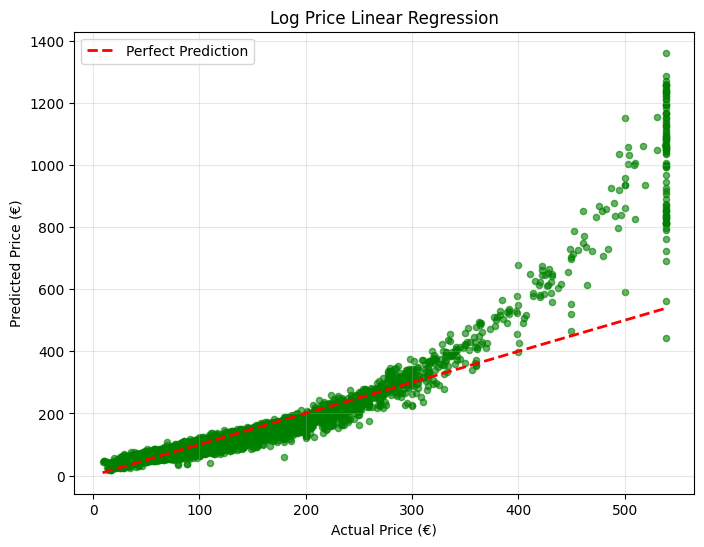

In [ ]:
#plot
y_actual_price_complete = np.concatenate([np.exp(y_train_log), np.exp(y_test_log)])
y_pred_price_complete = np.concatenate([y_train_pred, y_test_pred])

plt.figure(figsize=(8, 6))
plt.scatter(y_actual_price_complete, y_pred_price_complete, alpha=0.6, s=20, color='green')
plt.plot([y_actual_price_complete.min(), y_actual_price_complete.max()], 
         [y_actual_price_complete.min(), y_actual_price_complete.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Price (€)')
plt.ylabel('Predicted Price (€)')
plt.title('Log Price Linear Regression')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [12]:
import joblib

from pathlib import Path
Path("models").mkdir(exist_ok=True)

joblib.dump(model,  "../models/log_linear_model.pkl")

['../models/log_linear_model.pkl']